# Day 98: Building and Deploying Complete ML Pipelines

Welcome to Day 98 of the 100 Days of Machine Learning challenge! Today, we'll learn how to build robust, production-ready machine learning pipelines that integrate all the concepts we've learned throughout this journey.

## Introduction to ML Pipelines

### What is an ML Pipeline?

A **machine learning pipeline** is a systematic workflow that automates the machine learning process from raw data to predictions. It encapsulates all the necessary steps—data preprocessing, feature engineering, model training, and evaluation—into a single, reproducible unit.

### Why Use ML Pipelines?

Machine learning pipelines are essential for several reasons:

1. **Reproducibility**: Pipelines ensure that the same preprocessing steps are applied consistently to training and test data, reducing the risk of data leakage.
2. **Maintainability**: Code becomes more organized and easier to maintain when encapsulated in pipeline objects.
3. **Scalability**: Pipelines make it easier to deploy models to production environments.
4. **Prevention of Data Leakage**: By fitting preprocessing steps only on training data and transforming test data, pipelines help prevent data leakage.
5. **Hyperparameter Optimization**: Pipelines integrate seamlessly with cross-validation and grid search techniques.

### Learning Objectives

By the end of this lesson, you will be able to:

- Understand the architecture and components of ML pipelines
- Build pipelines using scikit-learn's `Pipeline` class
- Implement cross-validation with pipelines
- Perform hyperparameter tuning using GridSearchCV
- Apply best practices for building production-ready ML systems
- Compare multiple models within pipeline frameworks

## Theoretical Foundations

### Pipeline Architecture

An ML pipeline typically consists of two types of components:

1. **Transformers**: Objects that implement `fit()` and `transform()` methods (e.g., scalers, encoders)
2. **Estimators**: Objects that implement `fit()` and `predict()` methods (e.g., classifiers, regressors)

A pipeline chains multiple transformers followed by a final estimator. The data flows through each step sequentially:

$$\text{Raw Data} \xrightarrow{\text{Transform}_1} \text{Data}_1 \xrightarrow{\text{Transform}_2} \text{Data}_2 \xrightarrow{\text{Estimator}} \text{Predictions}$$

### Cross-Validation Mathematics

Cross-validation is a technique to assess model performance by partitioning the data into $k$ folds. For each fold $i$:

$$\text{Score}_i = \text{Performance}(\text{Model trained on } D \setminus D_i, \text{ tested on } D_i)$$

The final cross-validation score is the average:

$$\text{CV Score} = \frac{1}{k} \sum_{i=1}^{k} \text{Score}_i$$

The standard error provides insight into score variability:

$$\text{SE} = \sqrt{\frac{1}{k}\sum_{i=1}^{k}(\text{Score}_i - \text{CV Score})^2}$$

### Hyperparameter Optimization

Hyperparameter tuning involves finding the optimal configuration $\theta^*$ from a parameter space $\Theta$:

$$\theta^* = \arg\max_{\theta \in \Theta} \text{CV Score}(\theta)$$

Grid search exhaustively evaluates all combinations in the parameter grid, while random search samples randomly from the parameter space.

### Model Selection Criteria

When comparing models, we consider multiple criteria:

1. **Accuracy**: Proportion of correct predictions
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

2. **Precision**: Proportion of positive predictions that are correct
$$\text{Precision} = \frac{TP}{TP + FP}$$

3. **Recall (Sensitivity)**: Proportion of actual positives correctly identified
$$\text{Recall} = \frac{TP}{TP + FN}$$

4. **F1-Score**: Harmonic mean of precision and recall
$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


## Python Implementation

### Loading and Exploring the Dataset

We'll use the breast cancer dataset from scikit-learn, which is a classic binary classification problem. The dataset contains features computed from digitized images of breast mass, and the task is to predict whether the mass is malignant or benign.

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nTarget classes: {data.target_names}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569

Target classes: ['malignant' 'benign']
Class distribution: [212 357]


### Splitting the Data

We'll split our data into training and testing sets, using stratification to ensure both sets have the same class distribution.

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set size: 455
Testing set size: 114
Training set class distribution: [170 285]
Testing set class distribution: [42 72]


### Building a Basic Pipeline

Let's create our first pipeline that combines data scaling with logistic regression. The pipeline ensures that:

1. The scaler is fit only on the training data
2. The same scaling parameters are applied to the test data
3. Both steps are combined into a single object for easy deployment

In [4]:
# Create a simple pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the pipeline
accuracy = accuracy_score(y_test, y_pred)
print(f"Pipeline Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=data.target_names))

Pipeline Accuracy: 0.9825

Classification Report:

              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Cross-Validation with Pipelines

Cross-validation provides a more robust estimate of model performance by testing on multiple data splits. When using pipelines, the preprocessing steps are correctly applied within each fold.

In [5]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

Cross-Validation Scores: [0.96703297 0.97802198 0.96703297 1.         0.98901099]
Mean CV Score: 0.9802
Standard Deviation: 0.0128
95% Confidence Interval: [0.9551, 1.0053]


### Visualizing Cross-Validation Performance

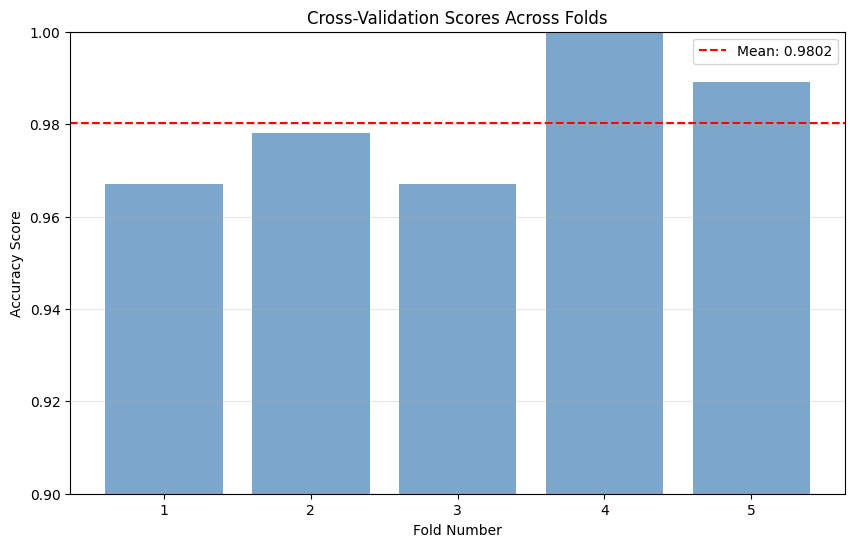

In [6]:
# Visualize cross-validation scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, color='steelblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores Across Folds')
plt.ylim([0.9, 1.0])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### Hyperparameter Tuning with GridSearchCV

GridSearchCV automates the process of finding optimal hyperparameters by exhaustively trying all combinations from a parameter grid. When combined with pipelines, we can tune hyperparameters for any step in the pipeline.

In [7]:
# Define parameter grid for logistic regression
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"\nTest Set Accuracy: {grid_search.score(X_test, y_test):.4f}")

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV Score: 0.9802

Test Set Accuracy: 0.9825


### Visualizing Hyperparameter Tuning Results

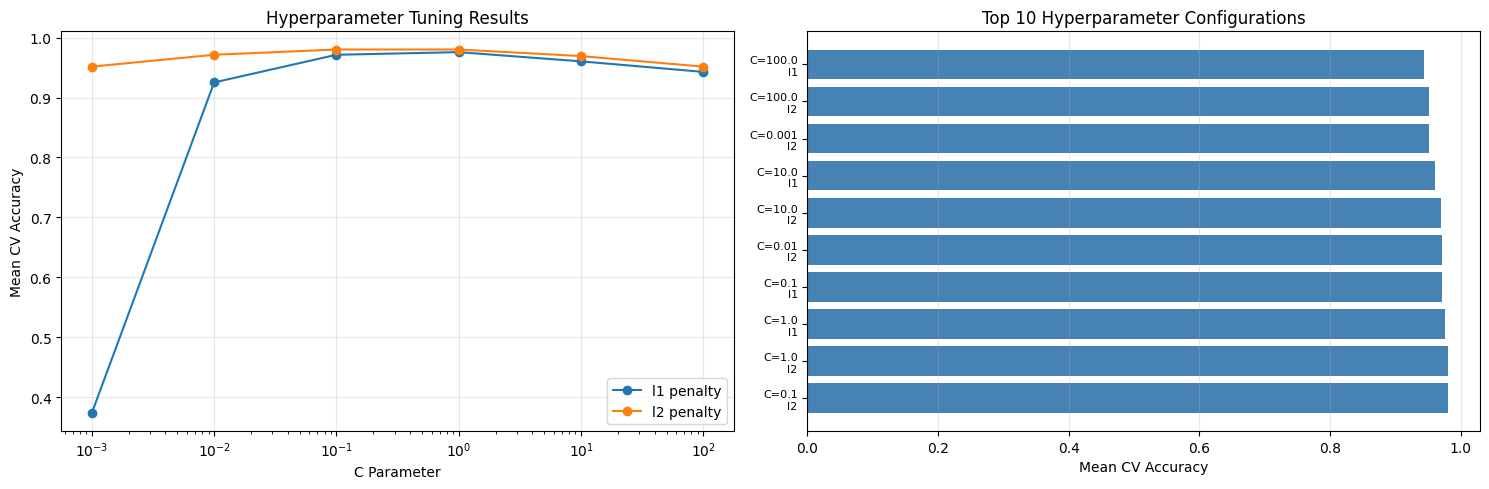

In [8]:
# Extract results from grid search
results_df = pd.DataFrame(grid_search.cv_results_)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Performance vs C parameter for each penalty
for penalty in ['l1', 'l2']:
    mask = results_df['param_classifier__penalty'] == penalty
    plot_data = results_df[mask]
    axes[0].plot(plot_data['param_classifier__C'], plot_data['mean_test_score'],
                 marker='o', label=f'{penalty} penalty')

axes[0].set_xscale('log')
axes[0].set_xlabel('C Parameter')
axes[0].set_ylabel('Mean CV Accuracy')
axes[0].set_title('Hyperparameter Tuning Results')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Top 10 configurations
top_10 = results_df.nlargest(10, 'mean_test_score')
x_labels = [f"C={row['param_classifier__C']}\n{row['param_classifier__penalty']}"
            for _, row in top_10.iterrows()]
axes[1].barh(range(10), top_10['mean_test_score'], color='steelblue')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(x_labels, fontsize=8)
axes[1].set_xlabel('Mean CV Accuracy')
axes[1].set_title('Top 10 Hyperparameter Configurations')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Comparing Multiple Models with Pipelines

One of the powerful aspects of pipelines is the ability to easily swap out different models while keeping the preprocessing steps constant. Let's compare three different algorithms.

In [9]:
# Define multiple pipelines with different classifiers
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=10000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

# Train and evaluate each pipeline
results = {}
for name, pipe in pipelines.items():
    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')

    # Train on full training set
    pipe.fit(X_train, y_train)

    # Test set performance
    test_score = pipe.score(X_test, y_test)

    results[name] = {
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Score': test_score
    }

    print(f"{name}:")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Score: {test_score:.4f}\n")

Logistic Regression:
  CV Score: 0.9802 (+/- 0.0128)
  Test Score: 0.9825

Random Forest:
  CV Score: 0.9538 (+/- 0.0235)
  Test Score: 0.9561

SVM:
  CV Score: 0.9714 (+/- 0.0179)
  Test Score: 0.9825



### Visualizing Model Comparison

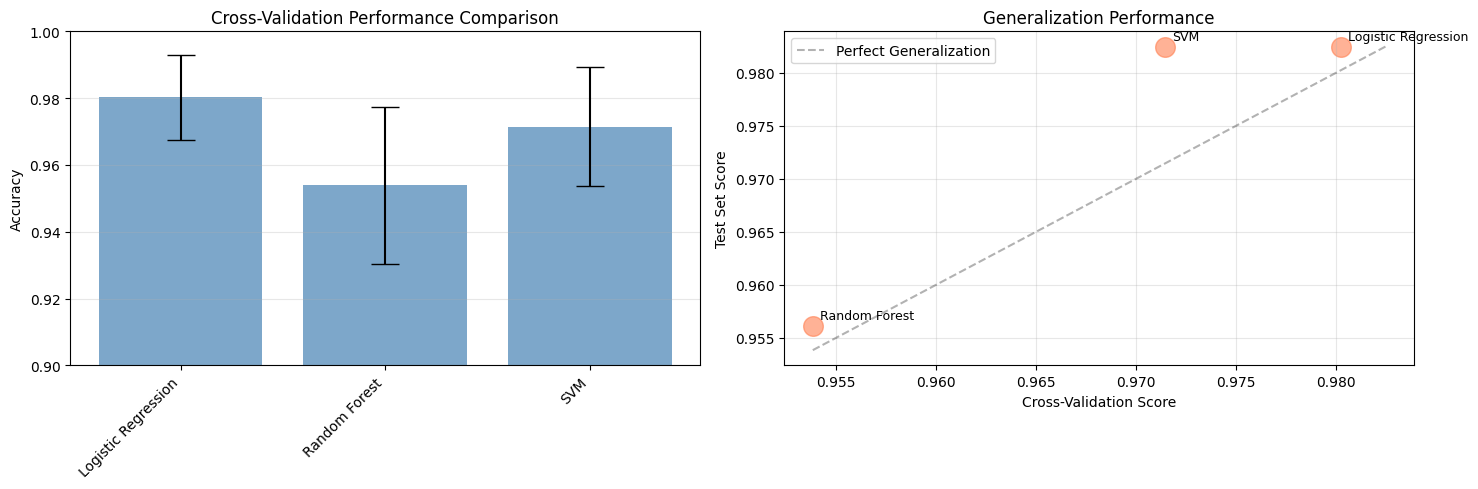

In [10]:
# Convert results to DataFrame for easier plotting
results_df_compare = pd.DataFrame(results).T

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: CV scores with error bars
x_pos = np.arange(len(results_df_compare))
axes[0].bar(x_pos, results_df_compare['CV Mean'], yerr=results_df_compare['CV Std'],
            alpha=0.7, capsize=10, color='steelblue')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df_compare.index, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Cross-Validation Performance Comparison')
axes[0].set_ylim([0.9, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: CV vs Test performance
axes[1].scatter(results_df_compare['CV Mean'], results_df_compare['Test Score'],
                s=200, alpha=0.6, color='coral')
for idx, name in enumerate(results_df_compare.index):
    axes[1].annotate(name,
                     (results_df_compare['CV Mean'].iloc[idx],
                      results_df_compare['Test Score'].iloc[idx]),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add diagonal line (perfect generalization)
min_val = min(results_df_compare['CV Mean'].min(), results_df_compare['Test Score'].min())
max_val = max(results_df_compare['CV Mean'].max(), results_df_compare['Test Score'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Perfect Generalization')
axes[1].set_xlabel('Cross-Validation Score')
axes[1].set_ylabel('Test Set Score')
axes[1].set_title('Generalization Performance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Detailed Model Evaluation

Let's examine the confusion matrix and classification report for our best model.

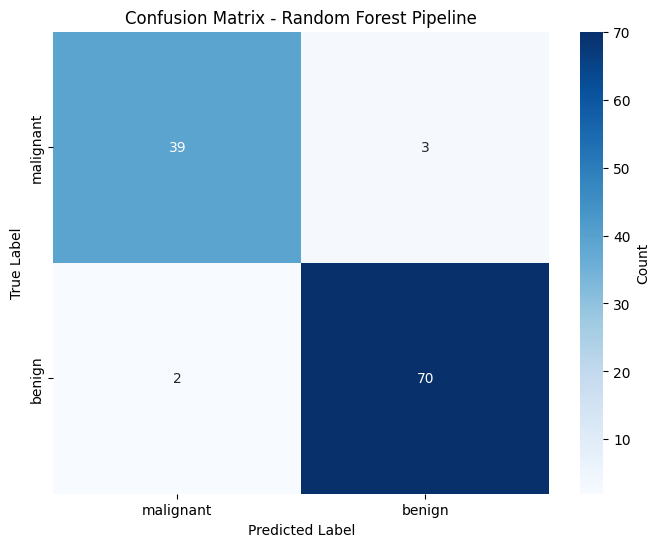


Detailed Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [11]:
# Get predictions from the best model
best_pipeline = pipelines['Random Forest']
y_pred_best = best_pipeline.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Pipeline')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

## Hands-On Activity: Building Your Own Pipeline

Now it's your turn! In this exercise, you'll build a complete machine learning pipeline from scratch.

### Exercise Instructions:

1. Use the provided code to generate a synthetic dataset
2. Create multiple pipelines with different preprocessing steps and models
3. Compare their performance using cross-validation
4. Select the best model and tune its hyperparameters
5. Evaluate the final model on the test set

### Starter Code:

In [12]:
# Generate a synthetic dataset for practice
from sklearn.datasets import make_classification

X_exercise, y_exercise = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.6, 0.4],
    random_state=42
)

# Split the data
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(
    X_exercise, y_exercise, test_size=0.2, random_state=42, stratify=y_exercise
)

print(f"Training set shape: {X_train_ex.shape}")
print(f"Test set shape: {X_test_ex.shape}")
print(f"Class distribution: {np.bincount(y_exercise)}")

# TODO: Create your pipelines here
# TODO: Perform cross-validation
# TODO: Tune hyperparameters
# TODO: Evaluate on test set

# Example pipeline to get you started:
example_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Train and evaluate
example_pipeline.fit(X_train_ex, y_train_ex)
print(f"\nExample Pipeline Test Accuracy: {example_pipeline.score(X_test_ex, y_test_ex):.4f}")

Training set shape: (800, 20)
Test set shape: (200, 20)
Class distribution: [602 398]

Example Pipeline Test Accuracy: 0.8100


## Key Takeaways

Congratulations on completing Day 98! Here are the main concepts you should take away from this lesson:

### Core Concepts

1. **ML Pipelines streamline the workflow**: Pipelines combine preprocessing, feature engineering, and model training into a single, reproducible unit.

2. **Prevention of data leakage**: By ensuring that preprocessing steps are fit only on training data and then applied to test data, pipelines help prevent data leakage.

3. **Cross-validation provides robust estimates**: Using k-fold cross-validation gives a better understanding of model performance than a single train-test split.

4. **Hyperparameter tuning is essential**: GridSearchCV and RandomizedSearchCV automate the search for optimal hyperparameters, improving model performance.

5. **Model comparison requires consistent evaluation**: Using pipelines ensures that all models are evaluated under the same preprocessing conditions.

### Best Practices

- Always use pipelines for production ML systems
- Set random seeds for reproducibility
- Use stratified splits for imbalanced datasets
- Evaluate multiple metrics, not just accuracy
- Document hyperparameter choices and their impact
- Keep preprocessing steps inside the pipeline to prevent leakage

### What's Next?

You now have the tools to build production-ready machine learning systems! In the upcoming lessons, we'll explore:
- Model deployment strategies
- Monitoring and maintaining models in production
- Handling model drift and retraining
- Final capstone project completion

## Further Resources

To deepen your understanding of ML pipelines and related topics, check out these resources:

### Official Documentation

1. **Scikit-learn Pipelines**: https://scikit-learn.org/stable/modules/compose.html
   - Comprehensive guide to building pipelines in scikit-learn

2. **GridSearchCV Documentation**: https://scikit-learn.org/stable/modules/grid_search.html
   - Detailed explanation of hyperparameter tuning methods

3. **Cross-Validation**: https://scikit-learn.org/stable/modules/cross_validation.html
   - Understanding different cross-validation strategies

### Tutorials and Articles

4. **Scikit-learn Pipeline Tutorial**: https://www.datacamp.com/tutorial/tutorial-machine-learning-pipelines-scikit-learn
   - Step-by-step tutorial on building ML pipelines

5. **Model Selection and Evaluation**: https://scikit-learn.org/stable/model_selection.html
   - Best practices for model selection and evaluation

### Books

6. **"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron**
   - Chapter on fine-tuning ML models and pipelines

7. **"Python Machine Learning" by Sebastian Raschka**
   - Comprehensive coverage of scikit-learn pipelines and best practices

### Research Papers

8. **"Hidden Technical Debt in Machine Learning Systems" (Google)**
   - https://papers.nips.cc/paper/2015/file/86df7dcfd896fcaf2674f757a2463eba-Paper.pdf
   - Understanding the importance of well-structured ML systems